In [1]:
import torch
import torchvision

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from torchvision import datasets, transforms
from torch.utils.data import TensorDataset, DataLoader
from torchvision import models
import torch.optim as optim
import torch.nn as nn
from torch.utils.data.dataloader import default_collate

import time
from PIL import Image

import warnings
warnings.filterwarnings("ignore")

import random
random.seed(42)

In [2]:
# torch.cuda.empty_cache() полностью чистит память графического процессора

In [7]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize(size=(224, 224), antialias = True),
    transforms.Normalize(mean=[0.4707, 0.4602, 0.4550],
                         std=[0.2638, 0.2629, 0.2678])
    ])

transform_rnd = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize(size=(224, 224), antialias = True),
    transforms.Normalize(mean=[0.4707, 0.4602, 0.4550],
                         std=[0.2638, 0.2629, 0.2678]),
    transforms.RandomAdjustSharpness(sharpness_factor=2),
    transforms.RandomAutocontrast(),
    transforms.RandomHorizontalFlip(),
    transforms.RandomAffine(degrees=35, translate=(0.3, 0.3))
    ])

BATCH_SIZE = 256
TEST_SIZE = 0.1

ROOT = ''
NET_NAME = '/content/drive/MyDrive/Учеба/Мага 1 курс 2 сем/Нейронные сети/Лаб4/mobilenet.pt'
DATASET_FOLDER = '/content/drive/MyDrive/Учеба/Мага 1 курс 2 сем/Нейронные сети/Лаб4/dataset_by_classes'
DATA_ROOT = DATASET_FOLDER

DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(DEVICE)

cuda:0


In [8]:
from torch.utils.data.dataset import ConcatDataset

dataset_orig = datasets.ImageFolder(DATASET_FOLDER, transform=transform)
dataset_rnd = datasets.ImageFolder(DATASET_FOLDER, transform=transform_rnd)

dataset = ConcatDataset([dataset_orig, dataset_rnd])

classes = dataset_orig.classes
print(classes)

['1', '10', '100', '101', '102', '103', '104', '105', '106', '107', '108', '109', '11', '110', '111', '112', '113', '114', '115', '116', '117', '118', '119', '12', '120', '121', '122', '123', '124', '125', '126', '127', '128', '129', '13', '130', '131', '132', '133', '134', '135', '136', '137', '138', '139', '14', '140', '141', '142', '143', '144', '145', '146', '147', '148', '149', '15', '150', '151', '152', '153', '154', '155', '156', '157', '158', '159', '16', '160', '161', '162', '163', '164', '165', '166', '167', '168', '169', '17', '170', '171', '172', '173', '174', '175', '176', '177', '178', '179', '18', '180', '181', '182', '183', '184', '185', '186', '187', '188', '189', '19', '190', '191', '192', '193', '194', '195', '196', '2', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29', '3', '30', '31', '32', '33', '34', '35', '36', '37', '38', '39', '4', '40', '41', '42', '43', '44', '45', '46', '47', '48', '49', '5', '50', '51', '52', '53', '54', '55', '56', '57', '58', '

In [9]:
test_len = int(TEST_SIZE*len(dataset))
train_set, test_set = torch.utils.data.random_split(dataset, [len(dataset)-test_len, test_len])
train_loader = torch.utils.data.DataLoader(train_set, batch_size=BATCH_SIZE, shuffle=True, 
                                        collate_fn=lambda x: tuple(x_.to(DEVICE) for x_ in default_collate(x)))
test_loader = torch.utils.data.DataLoader(test_set, batch_size=BATCH_SIZE, shuffle=True,
                                        collate_fn=lambda x: tuple(x_.to(DEVICE) for x_ in default_collate(x)))
print(len(train_set),len(test_set))

12577 1397


Image batch dimensions: torch.Size([256, 3, 224, 224])
Image label dimensions: torch.Size([256])


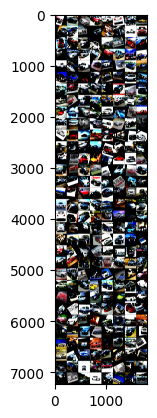

In [10]:
def imshow(img):
    img_np = img.cpu().numpy()
    plt.imshow(np.transpose(img_np, (1, 2, 0)))

dataiter = iter(train_loader)
images, labels = next(dataiter)

imshow(torchvision.utils.make_grid(images))

print("Image batch dimensions:", images.shape)
print("Image label dimensions:", labels.shape)

In [11]:
def save_model(model, path, name):
  model_scripted = torch.jit.script(model)
  model_scripted.save(path + name)

In [12]:
def my_accuracy(model, test_loader):
    correct = 0
    total = 0
    with torch.no_grad():
        model.eval()
        for data in test_loader:
            images, labels = data
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    print(f'Accuracy of the network on the {test_len} test images: {100 * correct // total} %')
    return 100 * correct // total

def my_accuracy_per_classes(model, test_loader, classes):
    correct_pred = {classname: 0 for classname in classes}
    total_pred = {classname: 0 for classname in classes}

    with torch.no_grad():
        model.eval()
        for data in test_loader:
            images, labels = data
            outputs = model(images)
            _, predictions = torch.max(outputs, 1)
            for label, prediction in zip(labels, predictions):
                if label == prediction:
                    correct_pred[classes[label]] += 1
                total_pred[classes[label]] += 1

    for classname, correct_count in correct_pred.items():
        accuracy = 100 * float(correct_count) / total_pred[classname]
        print(f'Accuracy for class: {classname:5s} is {accuracy:.1f} %')
    return correct_pred.items()

In [13]:
def fit(model, train_dataloader, optim, criterion):
    model.train()
    train_running_loss = 0.0
    all_loss = []
    for i, data in enumerate(train_dataloader):
        inputs, labels = data

        optim.zero_grad()
        output = model(inputs)
        loss = criterion(output, labels)
        loss.backward()
        optim.step()
        
        train_running_loss += loss.item()
        all_loss.append(loss.item())
        if (i+1) % 3 == 0 :
          print((i+1), '/', len(train_dataloader.dataset) / BATCH_SIZE, ': loss = ', loss.item())
        
    mean_loss = train_running_loss/ (len(train_dataloader.dataset) / BATCH_SIZE)
    print(f'Mean epoch loss: {mean_loss:.4f}')
    
    return mean_loss, all_loss

#mobile

In [14]:
model = models.mobilenet_v3_large(pretrained=True)
model

Downloading: "https://download.pytorch.org/models/mobilenet_v3_large-8738ca79.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v3_large-8738ca79.pth
100%|██████████| 21.1M/21.1M [00:00<00:00, 76.1MB/s]


MobileNetV3(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
      (2): Hardswish()
    )
    (1): InvertedResidual(
      (block): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=16, bias=False)
          (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
        )
        (1): Conv2dNormActivation(
          (0): Conv2d(16, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
        )
      )
    )
    (2): InvertedResidual(
      (block): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1), bi

In [15]:
for param in model.features.parameters():
    param.requires_grad = False    
    
model.classifier[3] = nn.Sequential(nn.Linear(1280, 512),
                                    nn.ReLU(inplace=True),
                                    nn.Linear(512, 196))
for param in model.classifier.parameters():
    param.requires_grad = True 

model.to(DEVICE)

MobileNetV3(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
      (2): Hardswish()
    )
    (1): InvertedResidual(
      (block): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=16, bias=False)
          (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
        )
        (1): Conv2dNormActivation(
          (0): Conv2d(16, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
        )
      )
    )
    (2): InvertedResidual(
      (block): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1), bi

In [18]:
# optimizer
optimizer = optim.Adam(model.classifier.parameters(), lr=0.001)
# loss function
criterion = nn.CrossEntropyLoss()
MAX_EPOCHS = 2

In [19]:
import gc
torch.cuda.empty_cache()
gc.collect()

34

In [20]:
epoch_mean_loss = []
all_loss = []

In [ ]:
for epoch in range(MAX_EPOCHS): 
    mean_loss, epoch_losses = fit(model, train_loader, optimizer, criterion)
    epoch_mean_loss.append(mean_loss)
    all_loss.extend(epoch_losses)
print('Finished Training')
save_model(model, '/', NET_NAME)

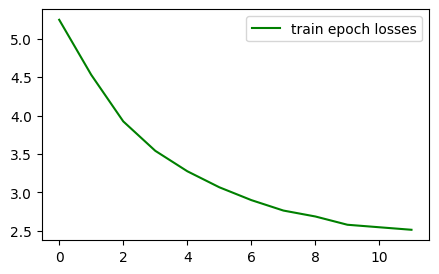

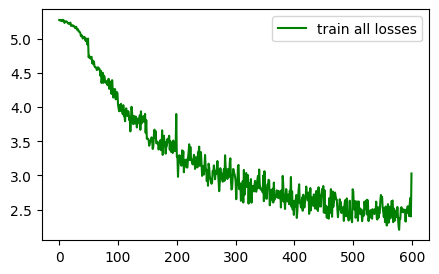

In [ ]:
plt.figure(figsize=(5, 3))
plt.plot(epoch_mean_loss, color='green', label='train epoch losses')
plt.legend()
plt.show()

plt.figure(figsize=(5, 3))
plt.plot(all_loss, color='green', label='train all losses')
plt.legend()
plt.show()

In [ ]:
my_accuracy(model, test_loader)

Accuracy of the network on the 1397 test images: 27 %


27

In [ ]:
my_accuracy_per_classes(model, test_loader, classes)

Accuracy for class: 1     is 55.6 %
Accuracy for class: 10    is 0.0 %
Accuracy for class: 100   is 50.0 %
Accuracy for class: 101   is 25.0 %
Accuracy for class: 102   is 60.0 %
Accuracy for class: 103   is 30.0 %
Accuracy for class: 104   is 42.9 %
Accuracy for class: 105   is 40.0 %
Accuracy for class: 106   is 42.9 %
Accuracy for class: 107   is 25.0 %
Accuracy for class: 108   is 11.1 %
Accuracy for class: 109   is 21.4 %
Accuracy for class: 11    is 83.3 %
Accuracy for class: 110   is 28.6 %
Accuracy for class: 111   is 33.3 %
Accuracy for class: 112   is 12.5 %
Accuracy for class: 113   is 14.3 %
Accuracy for class: 114   is 33.3 %
Accuracy for class: 115   is 25.0 %
Accuracy for class: 116   is 40.0 %
Accuracy for class: 117   is 11.1 %
Accuracy for class: 118   is 12.5 %
Accuracy for class: 119   is 35.7 %
Accuracy for class: 12    is 25.0 %
Accuracy for class: 120   is 0.0 %
Accuracy for class: 121   is 16.7 %
Accuracy for class: 122   is 16.7 %
Accuracy for class: 123   is 7

dict_items([('1', 5), ('10', 0), ('100', 4), ('101', 3), ('102', 6), ('103', 3), ('104', 3), ('105', 2), ('106', 3), ('107', 1), ('108', 1), ('109', 3), ('11', 5), ('110', 2), ('111', 1), ('112', 1), ('113', 1), ('114', 2), ('115', 3), ('116', 2), ('117', 1), ('118', 1), ('119', 5), ('12', 2), ('120', 0), ('121', 2), ('122', 1), ('123', 3), ('124', 3), ('125', 3), ('126', 2), ('127', 2), ('128', 0), ('129', 1), ('13', 0), ('130', 3), ('131', 1), ('132', 3), ('133', 1), ('134', 1), ('135', 1), ('136', 2), ('137', 1), ('138', 1), ('139', 0), ('14', 1), ('140', 2), ('141', 3), ('142', 1), ('143', 0), ('144', 2), ('145', 2), ('146', 4), ('147', 4), ('148', 2), ('149', 1), ('15', 1), ('150', 3), ('151', 5), ('152', 9), ('153', 3), ('154', 2), ('155', 2), ('156', 3), ('157', 4), ('158', 3), ('159', 2), ('16', 1), ('160', 2), ('161', 1), ('162', 4), ('163', 3), ('164', 1), ('165', 3), ('166', 5), ('167', 0), ('168', 3), ('169', 0), ('17', 2), ('170', 4), ('171', 2), ('172', 3), ('173', 0), ('